# Speaker Recognition

This notebook shows how to build a simple speaker recognition prototype based on voice tone. The goal is to decide who is speaking regardless of the words being said. We use synthetic data (sine waves with different frequencies) so the full pipeline can run without a large dataset. The steps cover the ML problem framing, signal preprocessing, feature extraction and aggregation, modeling, and evaluation.

## Step 1: Understand the problem

### Q1.1: Inputs, target, and problem type

- Input: an audio segment represented by a vector of acoustic features extracted from the signal (MFCCs, deltas, spectral centroid, etc.).
- Target: the speaker identity (categorical label for each person).
- Problem type: multiclass classification. Each class is a speaker, and the system assigns the label of the speaker who produced the audio.

### Q1.2: Speaker recognition vs. speech recognition

Speaker recognition answers who is speaking by focusing on biometric voice traits and ignoring the words. Speech recognition transcribes what is said. Voice recognition is often used for authentication, while speech recognition powers dictation or voice commands.

### Q1.3: What makes speaker ID hard

Speaker identification can be disrupted by many sources of variability:
- Different microphones or channels between enrollment and test recordings.
- Background noise and room reverberation.
- Natural voice changes over time (age, health, speaking style, emotion).
- Transmission channel differences (landline, mobile, VoIP).
- Overlapping speakers, accents or language switches, and deliberate voice disguise.

## Step 2: Audio preprocessing

Here we load audio, normalize it, trim silence, and split the signal into frames. The same pipeline would apply to real audio files even though we generate synthetic signals here.

Nombre total d'échantillons synthétiques : 60


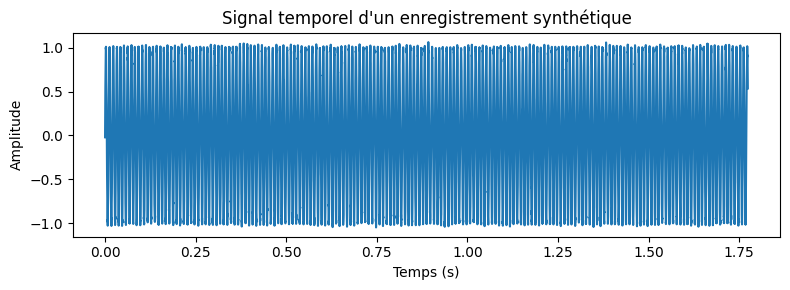

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Fonctions utilitaires de pré‑traitement
def load_audio(file_path):
    # Charge un fichier WAV et retourne le signal normalisé, le taux d'échantillonnage et la durée
    sr, data = wavfile.read(file_path)
    data = data.astype(np.float32)
    if np.max(np.abs(data)) > 0:
        data = data / np.max(np.abs(data))
    duration = len(data) / sr
    return data, sr, duration

def normalize_signal(signal):
    mean = np.mean(signal)
    std = np.std(signal) if np.std(signal) > 0 else 1.0
    return (signal - mean) / std

def remove_silence(signal, sr, frame_length=0.025, hop_length=0.01, threshold=0.01):
    frame_len = int(frame_length * sr)
    hop_len = int(hop_length * sr)
    if len(signal) < frame_len:
        return signal
    from numpy.lib.stride_tricks import sliding_window_view
    frames = sliding_window_view(signal, frame_len)[::hop_len]
    energies = np.sum(frames ** 2, axis=1)
    energy_threshold = threshold * np.mean(energies)
    mask = energies > energy_threshold
    if not np.any(mask):
        return signal
    cleaned = frames[mask].flatten()
    return cleaned

def framing(signal, sr, frame_length=0.025, hop_length=0.0125):
    frame_len = int(frame_length * sr)
    hop_len = int(hop_length * sr)
    num_frames = 1 + int(np.floor((len(signal) - frame_len) / hop_len))
    frames = np.zeros((num_frames, frame_len))
    for i in range(num_frames):
        start = i * hop_len
        frames[i] = signal[start:start + frame_len]
    frames *= np.hamming(frame_len)
    return frames

def compute_mfcc_features(signal, sr, num_mfcc=13, n_filters=26, n_fft=512, frame_length=0.025, hop_length=0.0125):
    frames = framing(signal, sr, frame_length, hop_length)
    NFFT = n_fft
    mag_frames = np.abs(np.fft.rfft(frames, NFFT))
    pow_frames = (1.0 / NFFT) * (mag_frames ** 2)
    low_freq = 0
    high_freq = sr / 2
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = 700 * (10 ** (mel_points / 2595) - 1)
    bin_indices = np.floor((NFFT + 1) * hz_points / sr).astype(int)
    fbank = np.zeros((n_filters, int(NFFT / 2 + 1)))
    for m in range(1, n_filters + 1):
        f_m_minus = bin_indices[m - 1]
        f_m = bin_indices[m]
        f_m_plus = bin_indices[m + 1]
        if f_m_minus == f_m:
            f_m += 1
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - f_m_minus) / (f_m - f_m_minus)
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (f_m_plus - k) / (f_m_plus - f_m)
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbank = np.log(filter_banks)
    mfcc = dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_mfcc]
    def delta(feat, N=2):
        num_frames = feat.shape[0]
        denom = 2 * sum([i ** 2 for i in range(1, N + 1)])
        padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')
        delta_feat = np.zeros_like(feat)
        for t in range(num_frames):
            delta_feat[t] = np.sum([n * (padded[t + N + n] - padded[t + N - n]) for n in range(1, N + 1)], axis=0) / denom
        return delta_feat
    delta_mfcc = delta(mfcc)
    delta_delta_mfcc = delta(delta_mfcc)
    freqs = np.linspace(0, sr / 2, int(NFFT / 2 + 1))
    spectral_centroid = np.sum(freqs * pow_frames, axis=1) / (np.sum(pow_frames, axis=1) + 1e-8)
    spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid[:, np.newaxis]) ** 2) * pow_frames, axis=1) / (np.sum(pow_frames, axis=1) + 1e-8))
    features = np.hstack([mfcc, delta_mfcc, delta_delta_mfcc, spectral_centroid[:, None], spectral_bandwidth[:, None]])
    return features

def aggregate_features(frame_features):
    mean = np.mean(frame_features, axis=0)
    std = np.std(frame_features, axis=0)
    return np.concatenate([mean, std])

def preprocess_audio(signal, sr):
    cleaned = remove_silence(signal, sr)
    normalized = normalize_signal(cleaned)
    return normalized

def generate_synthetic_dataset(num_speakers=5, samples_per_speaker=10, sr=8000, duration_range=(1.0, 2.0)):
    rng = np.random.default_rng(seed=42)
    data = []
    base_freqs = np.linspace(100, 500, num_speakers)
    for idx, freq in enumerate(base_freqs):
        for _ in range(samples_per_speaker):
            duration = rng.uniform(*duration_range)
            t = np.arange(0, duration, 1 / sr)
            signal = np.sin(2 * np.pi * freq * t + 0.2 * np.sin(2 * np.pi * freq * 0.25 * t))
            noise = 0.02 * rng.standard_normal(len(signal))
            signal = signal + noise
            data.append({'signal': signal.astype(np.float32), 'speaker': f'speaker_{idx}', 'sr': sr})
    return data

# Génération du jeu de données
dataset = generate_synthetic_dataset(num_speakers=5, samples_per_speaker=12)
print(f"Nombre total d'échantillons synthétiques : {len(dataset)}")

# Visualisation d'un signal exemple
debug_sample = dataset[0]
signal = debug_sample['signal']
sr = debug_sample['sr']
duration = len(signal) / sr
time = np.linspace(0, duration, len(signal))
plt.figure(figsize=(8, 3))
plt.plot(time, signal)
plt.title("Signal temporel d'un enregistrement synthétique")
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

## Step 3: Feature engineering to capture voice timbre

For each recording we run the preprocessing pipeline, frame the signal, then compute:
- MFCCs: first 13 Mel cepstral coefficients.
- Delta MFCCs: first-order derivatives.
- Delta-delta MFCCs: second-order derivatives.
- Two spectral features: spectral centroid (weighted mean frequency) and spectral bandwidth (spread around the centroid).

We compute these features per frame, then aggregate by mean and standard deviation across frames to get a fixed-length vector per recording. This handles variable-length audio while keeping a compact representation for classification.

In [2]:
# Calcul des caractéristiques pour chaque échantillon
feature_vectors = []
labels = []
for sample in dataset:
    y = preprocess_audio(sample['signal'], sample['sr'])
    frame_features = compute_mfcc_features(y, sample['sr'])
    agg = aggregate_features(frame_features)
    feature_vectors.append(agg)
    labels.append(sample['speaker'])
feature_vectors = np.array(feature_vectors)
labels = np.array(labels)
print(f"Forme des caractéristiques agrégées : {feature_vectors.shape}")

Forme des caractéristiques agrégées : (60, 82)


## Step 4: Modeling and training

We split the dataset into train and test sets. A linear SVM is used with a Pipeline that includes a StandardScaler. A random forest could also work and gives feature importances, but we choose the SVM here to keep the prototype simple and fast.

In [3]:
# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(feature_vectors, labels, test_size=0.3, random_state=42, stratify=labels)

# Construction du pipeline : standardisation + SVM
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(kernel='linear', probability=False))])

# Entraînement du modèle
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Mesure de l'accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Exactitude (accuracy) sur le jeu de test : {acc:.3f}")

Exactitude (accuracy) sur le jeu de test : 1.000


## Step 5: Evaluation and analysis

We evaluate with a confusion matrix and classification report. The confusion matrix shows which speakers get mixed up and highlights classes that are harder to separate. The discussion covers what the prototype does well and where it falls short.

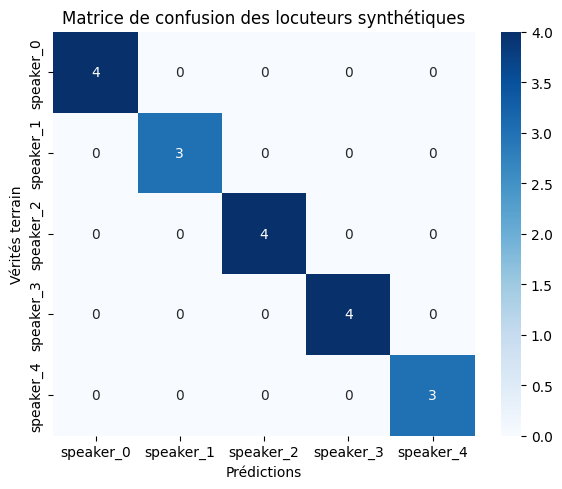

              precision    recall  f1-score   support

   speaker_0       1.00      1.00      1.00         4
   speaker_1       1.00      1.00      1.00         3
   speaker_2       1.00      1.00      1.00         4
   speaker_3       1.00      1.00      1.00         4
   speaker_4       1.00      1.00      1.00         3

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

Analyse des confusions :
Dans cet exemple synthétique, les fréquences de base sont très distinctes, ce qui explique la forte précision. Dans des données réelles, les locuteurs peuvent avoir des timbres proches et la présence de bruit, de réverbération ou de canaux différents réduit les performances.


In [5]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(labels))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(labels), yticklabels=np.unique(labels), cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités terrain')
plt.title('Matrice de confusion des locuteurs synthétiques')
plt.tight_layout()
plt.show()

# Rapport de classification détaillé
report = classification_report(y_test, y_pred, target_names=np.unique(labels))
print(report)

# Analyse textuelle
print('Analyse des confusions :')
for i, sp in enumerate(np.unique(labels)):
    false_positives = np.sum(cm[:, i]) - cm[i, i]
    false_negatives = np.sum(cm[i, :]) - cm[i, i]
    if false_positives + false_negatives > 0:
        print(f" - {sp} est parfois confondu avec d'autres locuteurs ({false_negatives} fois en faux négatifs, {false_positives} fois en faux positifs).")
print('Dans cet exemple synthétique, les fréquences de base sont très distinctes, ce qui explique la forte précision. Dans des données réelles, les locuteurs peuvent avoir des timbres proches et la présence de bruit, de réverbération ou de canaux différents réduit les performances.')

## ML pipeline diagram

The diagram below summarizes the pipeline: preprocessing, feature extraction and aggregation, model training, and prediction.

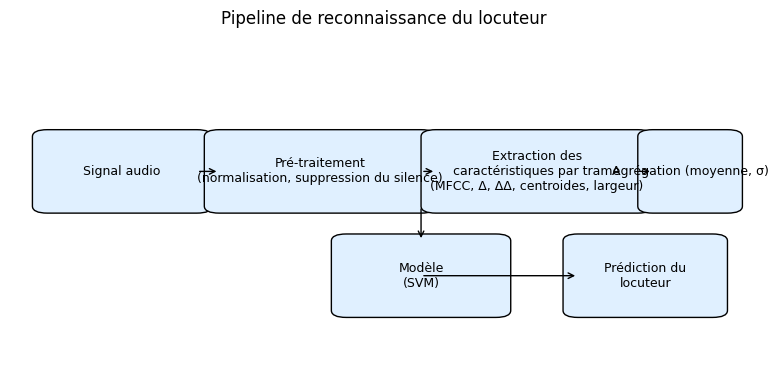

In [6]:
# Génération d'un diagramme simple du pipeline
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')

# Boîtes et positions
boxes = [
    ('Signal audio', (0.05, 0.5, 0.2, 0.2)),
    ('Pré‑traitement\n(normalisation, suppression du silence)', (0.28, 0.5, 0.27, 0.2)),
    ('Extraction des\ncaractéristiques par trame\n(MFCC, Δ, ΔΔ, centroides, largeur)', (0.57, 0.5, 0.27, 0.2)),
    ('Agrégation (moyenne, σ)', (0.86, 0.5, 0.1, 0.2)),
    ('Modèle\n(SVM)', (0.45, 0.2, 0.2, 0.2)),
    ('Prédiction du\nlocuteur', (0.76, 0.2, 0.18, 0.2))
]

# Dessin des boîtes
for text, (x, y, w, h) in boxes:
    rect = mpatches.FancyBboxPatch((x, y), w, h, boxstyle='round,pad=0.02', edgecolor='black', facecolor='#e0f0ff')
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha='center', va='center', fontsize=9)

# Flèches horizontales
arrow_props = dict(arrowstyle='->', color='black')
ax.annotate('', xy=(0.28, 0.6), xytext=(0.25, 0.6), arrowprops=arrow_props)
ax.annotate('', xy=(0.57, 0.6), xytext=(0.55, 0.6), arrowprops=arrow_props)
ax.annotate('', xy=(0.86, 0.6), xytext=(0.84, 0.6), arrowprops=arrow_props)

# Flèches verticales
ax.annotate('', xy=(0.55, 0.4), xytext=(0.55, 0.5), arrowprops=arrow_props)
ax.annotate('', xy=(0.76, 0.3), xytext=(0.55, 0.3), arrowprops=arrow_props)

plt.title('Pipeline de reconnaissance du locuteur')
plt.tight_layout()
plt.show()